## Advanced Lane Finding Project

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# Importing libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import math
from collections import deque
%matplotlib inline

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([])
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fit = deque([])
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


# Global Variables

In [51]:
left_lane = Line()
right_lane = Line()
lines = {"left": left_lane, "right":right_lane}

# Debug Mode 
DEBUG = False

# distortion matrix (run camera_calibration to get data)
dist_pickle = {}

# Repeatly used parameters
img_size = (720,1280)
ploty = np.linspace(0, img_size[0]-1, img_size[0])
recent_miss = 0

# HYPERPARAMETERS
# n interations records
n_record = 10

# conversion from pixel to meter
ym_per_pix = 30/720 
xm_per_pix = 3.7/1280

#mask cooefficient
half_height = img_size[0] //2
tuned_height = half_height + 95
half_width = img_size[1] //2
left_top = [half_width - 50,tuned_height]
left_bot = [185,img_size[0]]
right_top = [half_width + 50,tuned_height]
right_bot = [img_size[1] - 145,img_size[0]]
midpoint = img_size[1] // 2
MAX_FAIL_ATMPT = 10


# Camera Calibration
Reference from: [here](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb)

In [52]:
def camera_calibration(nx = 6,ny = 9):
    global dist_pickle
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('camera_cal/calibration*.jpg')
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    # Perform camera calibration given object points and image points
    retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result
    dist_pickle = {"mtx":mtx, "dist":dist}
    # dump to pickle file
    outfile = open("cam_cal.p", "wb")
    pickle.dump(dist_pickle, outfile)
    outfile.close()
    
    if DEBUG:
        # Test undistortion on an image
        img = cv2.imread('camera_cal/calibration1.jpg')
        img_size = (img.shape[1], img.shape[0])

        dst = cv2.undistort(img, mtx, dist, None, mtx)
        vis = np.concatenate((img, dst), axis=1)
        cv2.imwrite('output_images/calibration1_undist.jpg',vis)

    return {"mtx":mtx, "dist":dist}
if DEBUG:
    camera_calibration()
    assert(len(dist_pickle) == 2)

# Gradient Filtering 

In [53]:
def abs_sobelx_thresh(gray, sobel_kernel=3, thresh=(20, 100)):
    # create empty canvas
    grad_binary = np.zeros_like(gray)
    
    # Calculate gradient
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)       
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #draw on canvas
    grad_binary[((scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1]))] = 1
    
    return grad_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # create empty canvas
    binary_output = np.zeros_like(gray)
    
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    direct = np.arctan2(abs_y, abs_x)
    
    #draw on canvas
    binary_output[(direct > thresh[0]) & (direct < thresh[1])] = 1
    
    return binary_output

def filtering(gray_image, ksize = 3):
    # create empty canvas
    gradx_direct = np.zeros_like(gray_image)
    
    # x gradient filtering
    gradx = abs_sobelx_thresh(gray_image, sobel_kernel=ksize, thresh=(25, 200))
    
    # direciton gradient filtering
    dir_binary = dir_threshold(gray_image, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/4 + 0.3))
    
    # draw on canvas 
    gradx_direct[(gradx == 1) & (dir_binary == 1)] = 1
    
    return gradx, dir_binary, gradx_direct

def filtering_test():
    images = glob.glob('test_images/*.jpg') 
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        gradx, dir_binary, gradx_dir = filtering(path = path)
        output_path_x = 'output_images/filter_test/gradx_' + filename
        output_path_dir = 'output_images/filter_test/dir_' + filename
        output_path_x_dir = 'output_images/filter_test/x_dir_' + filename
        cv2.imwrite(output_path_x,gradx)
        cv2.imwrite(output_path_dir,dir_binary)
        cv2.imwrite(output_path_x_dir,dir_binary)


# Color Filtering

In [54]:
def color_filtering(hls, thresh = (100,255)):
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def color_test():
    images = glob.glob('test_images/*.jpg') 
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        S = color_filtering(img)
        output_path = 'output_images/color_test/' + filename
        cv2.imwrite(output_path,S)
if DEBUG:
    color_test()

# Perspective transform 

In [55]:
def perspective_transform(img, offset = 325, delta = -6):
    global half_height, tuned_height, half_width, left_top, left_bot, right_top, right_bot
    img_size = (img.shape[1],img.shape[0])
    right_top_temp = [right_top[0] - delta, right_top[1]]
    left_top_temp = [left_top[0] + delta, left_top[1]]
    src = np.float32([right_top_temp, right_bot, left_bot, left_top_temp])
    dst = np.float32([[img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]],
                      [offset, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped_undist = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_undist, M, Minv
def p_test():
    images = glob.glob('test_images/*.jpg')
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        warped_undist, M, Minv = perspective_transform(img)
        output_path = 'output_images/pt_test/' + filename
        cv2.imwrite(output_path,warped_undist)
if DEBUG:
    p_test()
        

In [56]:
def pipeline(img):
    global dist_pickle, lines
    # get calibration file
    if len(dist_pickle) == 0:
        try:
            infile = open("cam_cal.p",'rb')
            dist_pickle = pickle.load(infile)
        except:
            dist_pickle = camera_calibration()
    # undistortion
    img = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])
    
    # create gray image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # create hls iamge
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # gradient filtering
    _, _, gradx_direct = filtering(gray)

    # color filtering
    S = color_filtering(hls)

    # combine
    combined_binary = np.zeros_like(gradx_direct)
    combined_binary[(S == 1) | (gradx_direct == 1)] = 1

    # perspective transform
    pt_binary, M, Minv = perspective_transform(combined_binary)
    
    return pt_binary, M, Minv
    
if DEBUG:
    img = cv2.imread("test_images/straight_lines1.jpg")
    pt_binary, M, Minv = pipeline(img)
    cv2.imwrite("output_images/pipeline_test/straight_lines1.jpg",pt_binary)

# Find Lanes

In [57]:
def find_lane_pixels(binary_warped):
    global midpoint
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox > win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox > win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    global DEBUG, ploty
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ## Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if DEBUG:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
    
    return left_fit, right_fit
def fit_poly_with_prev(binary_warped, margin = 100):
    global DEBUG, lines, ploty

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (lines["left"].recent_fit[0][0]*nonzeroy**2 + lines["left"].recent_fit[0][1]*nonzeroy + lines["left"].recent_fit[0][2] - margin)) &(nonzerox < (lines["left"].recent_fit[0][0]*nonzeroy**2 + lines["left"].recent_fit[0][1]*nonzeroy + lines["left"].recent_fit[0][2] + margin)))
    right_lane_inds = ((nonzerox > (lines["right"].recent_fit[0][0]*nonzeroy**2 + lines["right"].recent_fit[0][1]*nonzeroy + lines["right"].recent_fit[0][2] - margin)) &(nonzerox < (lines["right"].recent_fit[0][0]*nonzeroy**2 + lines["right"].recent_fit[0][1]*nonzeroy + lines["right"].recent_fit[0][2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if DEBUG:
        ## Visualization ##
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(result)
    
    return left_fit, right_fit
    

# Helper Functions

In [64]:
def clean_line():
    global lines
    left_lane = Line()
    right_lane = Line()
    lines = {"left": left_lane, "right":right_lane}
    print("Line info cleaned")

def sanity_check(left_fit, right_fit, curv_left, curv_right):
    global xm_per_pix, ploty, DEBUG
    if not lines["left"].detected or not lines["right"].detected:
        return True, 0
    #Checking that they have similar curvature
    cur_diff = abs(curv_left - curv_right)
    if cur_diff > 100000:
        if DEBUG:
            print("cur diff failed")
        return False, 0
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Checking that they are separated by approximately the right distance horizontally
    lane_dist = abs((left_fitx[-1] - right_fitx[-1]) * xm_per_pix)
    dist_left = abs((midpoint - left_fitx[0]) * xm_per_pix)
    if lane_dist < 1.5 or lane_dist > 6:
        if DEBUG:
            print("lane distance failed")
        return False, dist_left
    
    #Checking that they are roughly parallel
    if abs(curv_left/lines["left"].radius_of_curvature) > 3  or abs(curv_left/lines["left"].radius_of_curvature) < 0.3 or abs(curv_right/lines["right"].radius_of_curvature) > 3 or abs(curv_right/lines["right"].radius_of_curvature) < 0.3:
        return False, dist_left
    return True, dist_left

def line_missing():
    global lines
    return not lines["left"].detected or not lines["right"].detected

def get_curv(img_shape, left_fit, right_fit):
    global ym_per_pix, xm_per_pix
    ploty = np.linspace(0, img_shape[1] -1, num=img_shape[1])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0] *(y_eval * ym_per_pix) + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0] *(y_eval * ym_per_pix) + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
    
def update_line(isValid, left_fit, right_fit, curv_left, curv_right):
    global lines, xm_per_pix, midpoint, recent_miss, ploty, DEBUG, MAX_FAIL_ATMPT, recent_miss
    if not isValid:
        recent_miss += 1
        if recent_miss > MAX_FAIL_ATMPT:
            lines["left"].detected = False
            lines["right"].detected = False
        return
    recent_miss = 0
    keys = ["left","right"]
    fit = {"left":left_fit,"right":right_fit}
    curv = {"left":curv_left,"right":curv_right}
    for key in keys:
        lines[key].detected = True
        # polynomial coefficients of the last n fits of the line
        lines[key].recent_fit.appendleft(fit[key])
        if len(lines[key].recent_fit) > n_record:
            lines[key].recent_fit.pop()

        #polynomial coefficients averaged over the last n iterations
        lines[key].best_fit = np.average(lines[key].recent_fit, axis = 0)
        
        #average x values of the fitted line over the last n iterations
        lines[key].bestx = lines[key].best_fit[0]*ploty**2 + lines[key].best_fit[1]*ploty + lines[key].best_fit[2]
        
        #radius of curvature of the line in some units
        lines[key].radius_of_curvature = curv[key]

        #distance in meters of vehicle center from the line
        lines[key].line_base_pos = (midpoint - fit[key]) * xm_per_pix
    if DEBUG:
        print_lane()

def print_lane():
    global lines
    keys = ["left","right"]
    for key in keys:
        print("{} lane status:".format(key))
        print("====================")
        print("recent_fit length:{}".format(len(lines[key].recent_fit)))
        print("best_fit: {}".format(lines[key].best_fit))

# Lane Extraction


In [65]:
def lane_extraction(img):
    global lines
    # image processing
    pt_binary, M, Minv = pipeline(img)
    
    # check line status
    if line_missing():
        # get line info from scratch
        left_fit, right_fit = fit_polynomial(pt_binary)
    else:
        # get line info from previous status
        left_fit, right_fit = fit_poly_with_prev(pt_binary)
        
    curv_left, curv_right = get_curv(pt_binary.shape, left_fit, right_fit)
    isValid,dist_to_left = sanity_check(left_fit, right_fit, curv_left, curv_right)
    update_line(isValid, left_fit, right_fit, curv_left, curv_right)
    #draw
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(pt_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0] -1, num=img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([lines["left"].bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lines["right"].bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cleft = 'Left Curvature:{}m'.format(math.floor(curv_left))
    cright = 'Right Curvature:{}m'.format(math.floor(curv_right))
    dist = 'Car is {}m left to center'.format(round(dist_to_left,2))
    cv2.putText(result, cleft,(10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(result, cright,(10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(result, dist,(10, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    plt.imshow(result)
    return result

if DEBUG:
    clean_line()
    images = glob.glob('test_images/straight_line*.jpg')
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        print("extracting {}".format(filename))
        print("- - - - - - - - - - -")
        result = lane_extraction(img)
        output_path = 'output_images/extract_test/' + filename
        cv2.imwrite(output_path,result)


In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_image(image):
    result = lane_extraction(image)
    return result

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Line info cleaned
Moviepy - Building video project_video_extract.mp4.
Moviepy - Writing video project_video_extract.mp4



Moviepy - Done !
Moviepy - video ready project_video_extract.mp4
CPU times: user 14min 42s, sys: 41.2 s, total: 15min 23s
Wall time: 1min 52s


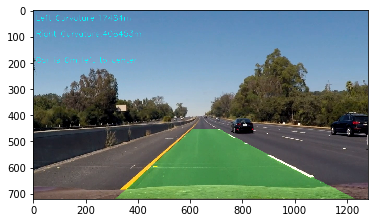

In [68]:
# %%capture
white_output = 'project_video_extract.mp4'
##for a subclip of the first 5 seconds: clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clean_line()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))